# CS 773 Data Mining and Security

## Course Project - Analyzing Open University Learning Analytics Dataset 

### Problem Statement 

Based on the given data of students enrolled in various courses identify the student who is at-risk so that suitable interventions can be taken to help students succeed. 

***Part-3 : Preprocessing and Feature Engineering***

In this part we will try to extract the features based on the insights and inferences from EDA.

In [1]:
#importing Libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# Reading Data
student_info = pd.read_csv('../data/studentInfo.csv')
student_assessment = pd.read_csv('../data/studentAssessment.csv')
student_registration = pd.read_csv('../data/studentRegistration.csv')
student_vle = pd.read_csv('../data/studentVle.csv')
assessments = pd.read_csv('../data/assessments.csv')
courses = pd.read_csv('../data/courses.csv')
vle = pd.read_csv('../data/vle.csv')

#check for the data
print('----- Rows -----')
print('Courses     : ',courses.shape[0])
print('Assessments : ',assessments.shape[0])
print('vle(Virtual Learning Environment) : ',vle.shape[0])
print('Student Info         : ',student_info.shape[0])
print('student Assessment   : ',student_assessment.shape[0])
print('student Registration : ',student_registration.shape[0])
print('student Vle          : ',student_vle.shape[0])

----- Rows -----
Courses     :  22
Assessments :  206
vle(Virtual Learning Environment) :  6364
Student Info         :  32593
student Assessment   :  173912
student Registration :  32593
student Vle          :  10655280


### Feature Extraction from student_info

In [ ]:
# Import required packages
from sklearn import preprocessing

***For Calculation purpose we encode the categorical data***

Label Encoding : Only for the Final variable

*In this case*

distinction  - 0

fail  - 1

pass  - 2

withdrawn - 3

One-Hot Encoding

C:\Users\HERAM\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


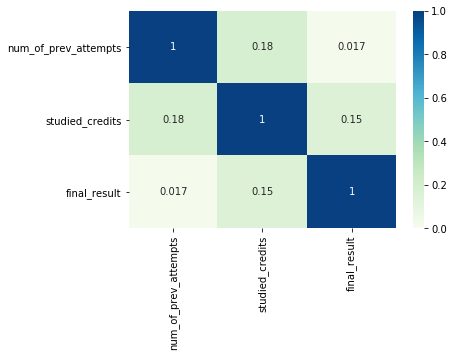

In [47]:
# generating heatmap and mapping correlation matrix -- Using Demographic info -- student_info
#student_info.info() #--- to get info
#student_info.isnull().sum() #--- No NULL Columns
# breaking the data frame into categorical and non categorical value to get the correlation matrix
#as student id is unique we might not require that 
#--- columns num_prev_attempts, studied_credits
student_info_numeric = student_info[['num_of_prev_attempts','studied_credits', 'final_result']]
#--- as final_result is a categorical column we can convert that into numeric using label_encoding
labelEncoder = preprocessing.LabelEncoder()
student_info_numeric['final_result'] = labelEncoder.fit_transform(student_info_numeric['final_result'])
#student_info_numeric.corr()
sns.heatmap(student_info_numeric.corr(), annot = True, vmin = 0, cmap = 'GnBu')

 We can see that in predicting final_result, ***studied_credits*** have a very strong impact compared to prevous attmepts
 
 we can also use columns like highest_education, age_band

In [50]:
student_info.info() #--- to get info

num_of_prev_attempts    0.016839
studied_credits         0.152596
final_result            1.000000
Name: final_result, dtype: float64

In [74]:
OHencoder= preprocessing.OneHotEncoder()
student_bg = student_info[['highest_education','region','final_result']]
pd.get_dummies(student_bg[['highest_education','region']])
#student_bg['highest_education'] = labelEncoder.fit_transform(student_bg['highest_education'])
#student_bg['region'] = labelEncoder.fit_transform(student_bg['region'])

#x = OHencoder.fit_transform(student_bg['highest_education']).to_Array()

,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region
0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


### feature extraction from student_assessment

In [75]:
student_assessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
id_assessment     173912 non-null int64
id_student        173912 non-null int64
date_submitted    173912 non-null int64
is_banked         173912 non-null int64
score             173912 non-null object
dtypes: int64(4), object(1)
memory usage: 6.6+ MB


### Feature Extraction from student_vle

- Based on the insights from Part1, we can create 2 data frames, 1 for having mean of total number of clicks for whole course, 2 for having the distribution of clicks for all the assessments individually. 

- extract the feature of the student, in VLE context we know that the usefulthing is number of clicks, but the clicks vary by many activity_types mapped with id_site in vle_table, based on the inference from EDA we can extract the information by taking  ***assessment_deadline*** and comparing it with ***date*** column in student_vle to calculate the number of clicks before that assessment, in this way we can use the data to predict the final_result.


***Creating a dataframe by merging student_info with student_clicks for particular course***

In [94]:
#student_vle.info()
student_clicks = student_vle.groupby(['id_student', 'code_module', 'code_presentation']).agg({'sum_click':['mean','sum']})
student_clicks.reset_index(level=[0,1,2], inplace=True)
student_clicks.columns = ['id_student', 'code_module', 'code_presentation', 'mean_clicks', 'sum_clicks']
#student_clicks
# merging student_clicks with student info
student_course_info = pd.merge(student_info,student_clicks, how='left', left_on=['id_student', 'code_module', 'code_presentation'],right_on=['id_student', 'code_module', 'code_presentation'])
student_course_info.reset_index(level=[0], inplace=True)
student_course_info

,index,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,mean_clicks,sum_clicks
0,0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,4.765306,934.0
1,1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,3.337209,1435.0
2,2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,3.697368,281.0
3,3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,3.254902,2158.0
4,4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,2.937500,1034.0
5,5,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,3.381743,2445.0
6,6,AAA,2013J,45462,M,Scotland,HE Qualification,30-40%,0-35,0,60,N,Pass,4.202817,1492.0
7,7,AAA,2013J,45642,F,North Western Region,A Level or Equivalent,90-100%,0-35,0,120,N,Pass,2.689266,1428.0
8,8,AAA,2013J,52130,F,East Anglian Region,A Level or Equivalent,70-80%,0-35,0,90,N,Pass,3.193929,1894.0
9,9,AAA,2013J,53025,M,North Region,Post Graduate Qualification,?,55<=,0,60,N,Pass,3.493363,3158.0


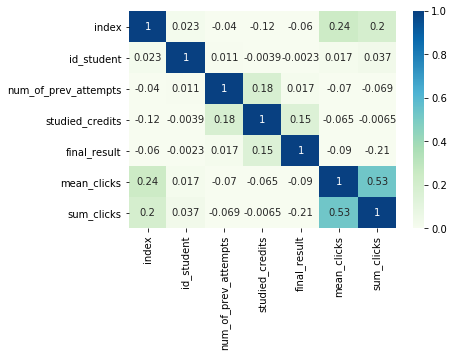

In [95]:
student_course_info['final_result'] = labelEncoder.fit_transform(student_course_info['final_result'])
sns.heatmap(student_course_info.corr(), annot = True, vmin = 0, cmap = 'GnBu')

*** by seeing the above heatmap of correlation we can say that number of clicks might not be an important feature at all as the show less correlation with the final_result***